In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Searching and Grouping Similar Images using Gemini Multimodal Embeddings

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/embeddings/similar_image_search_and_clustering.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fembeddings%2Fsimilar_image_search_and_clustering.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/embeddings/similar_image_search_and_clustering.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/embeddings/similar_image_search_and_clustering.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>    
</table>

| | |
|-|-|
|Author(s) | [Aakash Gouda](https://github.com/aksstar), Saloni Badjatya |

## Overview

[Embeddings](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-multimodal-embeddings) are numerical representations of text, images, or videos that capture relationships between inputs. Machine learning models, especially generative AI models, are suited for creating embeddings by identifying patterns within large datasets.

### Objectives

In this notebook, you will 

- Generate Multimodal embeddings of the files in dataset
- Perform Similarity Search
- Cluster/Group Similar images

### Costs

- This notebook uses billable components of Google Cloud:
  - Vertex AI

- Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Python Libraries

In [1]:
! pip install --quiet --upgrade --user google-cloud-aiplatform google-cloud-storage chromadb matplotlib numpy hdbscan Pillow

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel will restart. Please wait until it completes before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [3]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [1]:
# Define project information
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

# Import libraries


In [ ]:
import io

from PIL import Image as PIL_Image  # Import PIL
import chromadb
from google.cloud import storage
import hdbscan
import matplotlib.pyplot as plt
from vertexai.generative_models import GenerativeModel, Part
from vertexai.vision_models import Image, MultiModalEmbeddingModel

# Access images stored in GCS
- This Tutorial requires you manually download the dataset and upload images dataset in a GCS bucket.
- We use [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) in this notebook

In [3]:
def list_files_in_folder(bucket_name, folder_name):
    """Lists all the files within a specific folder in a GCS bucket and returns their GCS URIs.

    Args:
        bucket_name: The name of the GCS bucket.
        folder_name: The name of the folder within the bucket.

    Returns:
        A list of GCS URIs for files within the specified folder.
    """

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    # Ensure folder_name ends with a slash for proper prefix matching
    if not folder_name.endswith("/"):
        folder_name += "/"

    blobs = bucket.list_blobs(prefix=folder_name)

    # Construct the full GCS URI for each blob and filter out the folder itself
    file_uris = [
        f"gs://{bucket_name}/{blob.name}" for blob in blobs if blob.name != folder_name
    ]

    return file_uris


# Example usage (replace with your actual bucket and folder names)
bucket_name = "aakash-test-env"  # Replace with your actual bucket name
folder_name = "dataset/cats/"
file_uris = list_files_in_folder(bucket_name, folder_name)

if file_uris:
    print(f"Found '{len(file_uris)}' Files in folder '{folder_name}':")
else:
    print(f"No files found in folder '{folder_name}'.")

Found '149' Files in folder 'dataset/cats/':


### Load the Gemini Pro model and Multimodal Embedding model

To load the Gemini 1.5 Pro model, provide **gemini-1.5-pro-001** as an argument to **GenerativeModel** constructor.

In [12]:
mm_model = GenerativeModel("gemini-1.5-pro-001")
mm_embeddings_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

# Generate Multimodal embeddings of the files in dataset
The `get_image_embedding_from_gcs_uri` function can be used to generate image and text embeddings using multimodalembedding model.

In [5]:
def get_image_embedding_from_gcs_uri(image_uri):
    """Gets the image and text embeddings from a GCS URI.

    Args:
      image_uri: The GCS URI of the image.

    Returns:
      A tuple of the text embedding and the image embedding.
    """

    # Generate a content request for the image.
    response = mm_model.generate_content(
        [
            Part.from_uri(
                image_uri,
                mime_type="image/jpeg",
            ),
            "What is shown in this image? Give 3 to 5 keywords as output in the form of comma sepreated string without any stopwords for NLP processing",
        ]
    )

    # Get the text and image from the response.
    text = response.text
    image = Image.load_from_file(image_uri)

    # Get the embeddings for the image and text.
    embeddings = mm_embeddings_model.get_embeddings(image=image, contextual_text=text)

    # Return the embeddings.
    return embeddings.text_embedding, embeddings.image_embedding


image_embeddings_dict = {}
text_embeddings_dict = {}
for image_uri in file_uris:
    # Get the embeddings for the image.
    text_embedding, image_embedding = get_image_embedding_from_gcs_uri(image_uri)

    # Add the embeddings to the dictionaries.
    image_embeddings_dict.update({image_uri: image_embedding})
    text_embeddings_dict.update({image_uri: text_embedding})

# Setting up ChromaDB
Chroma DB is an open-source vector store used for storing and retrieving vector embeddings. Its main use is to save embeddings along with metadata to be used later by large language models.

- Initalize the chomadb client with persistent storage.
- Create Collection
- Add Embeddings generated to collection

In [8]:
# 1. Initialize ChromaDB Client
client = chromadb.PersistentClient(path="/home/jupyter/phlips")

# 2. Create a Collection
collection = client.create_collection(name="pets_image_embeddings")

In [9]:
# 3. Add Image Embeddings to the Collection
collection.add(
    embeddings=list(image_embeddings_dict.values()),
    ids=list(
        image_embeddings_dict.keys()
    ),  # Replace with your actual IDs, ensure same length as embeddings
)

# Perform Similarity Search
- Load test image
- Query collection
- Filter based on similarirty threshold

In [15]:
# Test image
image_uri = "gs://aakash-test-env/dataset/cats/Bombay_2.jpg"
text_embedding, image_embedding = get_image_embedding_from_gcs_uri(image_uri)

In [ ]:
results = collection.query(
    query_embeddings=image_embedding, n_results=5  # Number of similar results to return
)

# Filter results based on distance threshold
distance_threshold = 0.5

IMAGE_URIs = []
for i in range(len(results["distances"][0])):
    if results["distances"][0][i] < distance_threshold:
        IMAGE_URIs.append(results["ids"][0][i])

# Display Images in Notebook
You will do that in the cell below. An axuillary function to display images in grid is also provided.

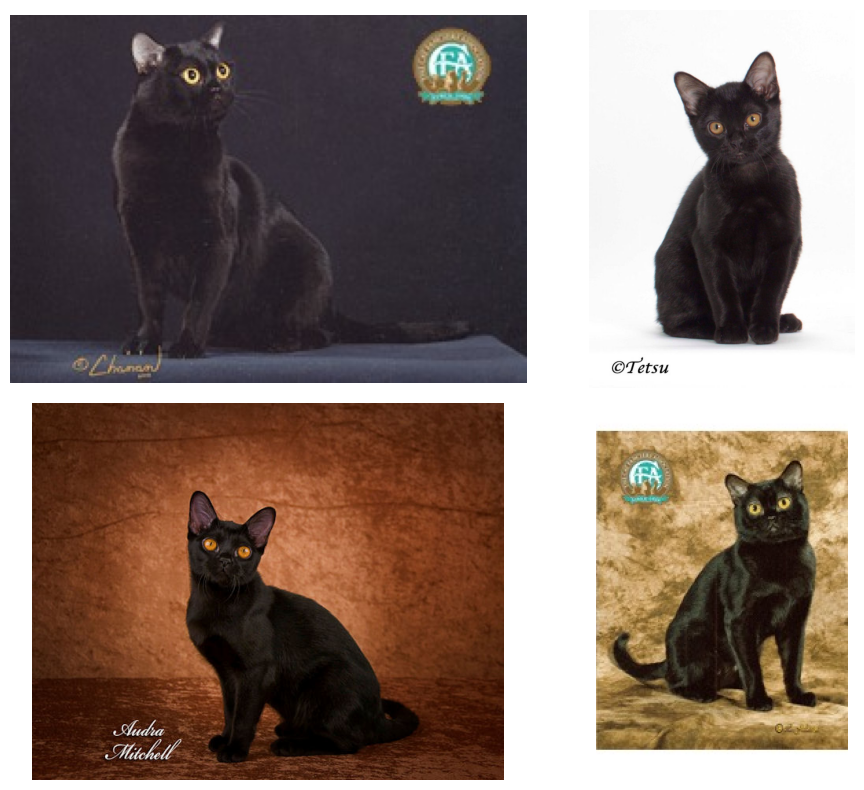

In [17]:
# Google Cloud Storage bucket name and file URIs
BUCKET_NAME = "aakash-test-env"


def display_images(IMAGE_URIS):
    # Initialize a Google Cloud Storage client
    storage_client = storage.Client()
    bucket = storage_client.bucket(BUCKET_NAME)

    # Calculate the number of rows and columns for the subplots
    n_images = len(IMAGE_URIS)
    ncols = 2  # You can adjust this
    nrows = (n_images + ncols - 1) // ncols

    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Iterate through the image URIs and display them
    for i, image_uri in enumerate(IMAGE_URIS):
        # Extract the blob name from the URI
        blob_name = image_uri.split("/")[-1]
        blob = bucket.blob(f"dataset/cats/{blob_name}")

        # Download the image data into a BytesIO object
        image_data = io.BytesIO(blob.download_as_bytes())
        # Open the image using PIL.Image
        image = PIL_Image.open(image_data)
        # image = image.convert("RGB")  # Convert to RGB
        # image = plt.imread(image)

        # Open the image using plt.imread()
        # image = plt.imread(image_data)

        # Display the image in the corresponding subplot
        axes[i].imshow(image)
        axes[i].axis("off")

    # Hide any unused subplots
    for i in range(n_images, nrows * ncols):
        axes[i].axis("off")

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


display_images(IMAGE_URIs)

# Clustering/Grouping Similar images
HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection. 

In [18]:
filenames = list(image_embeddings_dict.keys())
embeddings = list(image_embeddings_dict.values())

In [19]:
# Initialize HDBSCAN clusterer with specified parameters
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=4,  # Minimum number of points to form a cluster
    alpha=0.3,  # Smoothing parameter for the cluster hierarchy
)
clusterer.fit(embeddings)  # Fit the clusterer to the embedding data

HDBSCAN(alpha=0.3, min_cluster_size=4)

In [20]:
labels = clusterer.labels_  # Get the cluster labels for each data point
labels  # Display the cluster labels

array([ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  6,  5,  6,  5,  5,  5,  5,
        5,  5,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2, -1,  2,  2,
        2,  2,  2, -1, -1, -1,  3,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  7, -1, -1, -1, -1, -1, -1,  7,  7,  7,  7,
        7, -1, -1,  7,  7,  7, 13, 13, 13, 13, 13, 13, 13, -1, 13, 13, 12,
       -1, 12, 12, -1, 12, 12, 12, 12, 12,  7,  7,  7, -1,  7, -1, -1,  7,
        7,  7,  8, -1,  8, 11, 11, -1, 11,  8,  8,  9,  9,  9,  9,  9, -1,
        9,  9,  9,  9,  4,  4,  4,  4,  4,  4,  4,  4, -1,  4, -1, 10, 10,
       10, 10, 10, 10, 10, -1, 11, 11, 11, 11, 11, 11, 11])

# Visualizing the clusters

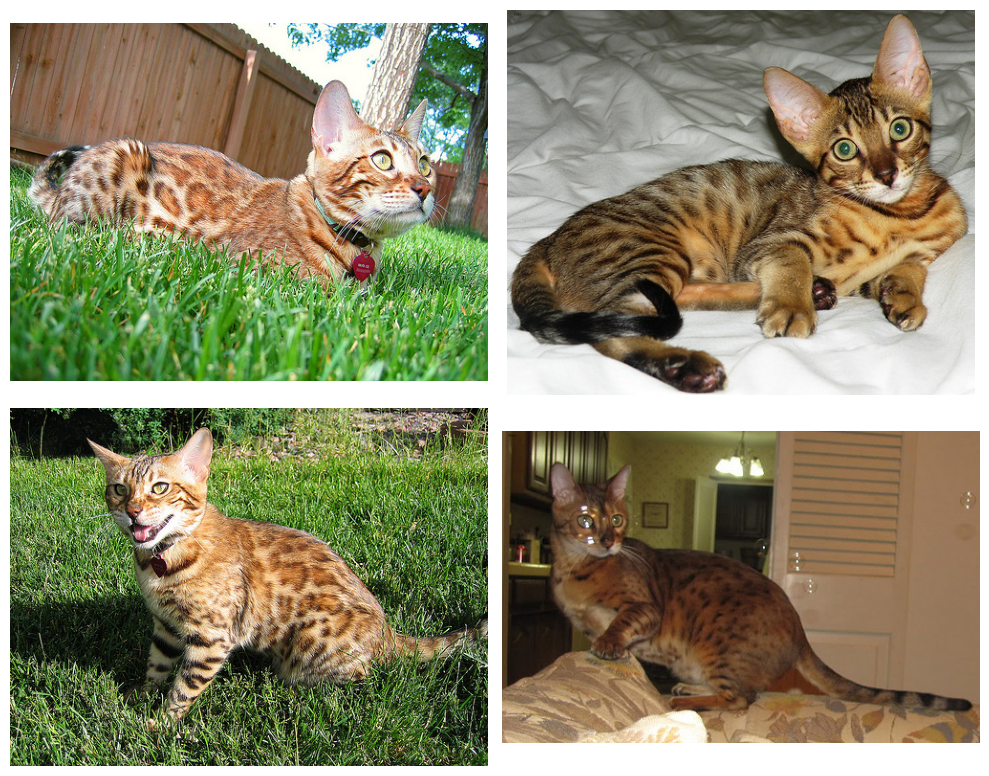

In [21]:
cluster_label = 5  # Choose a specific cluster label to visualize

# Get the image URIs corresponding to the chosen cluster label
IMAGE_URIs = [filenames[i] for i, val in enumerate(labels) if val == cluster_label][:4]

display_images(IMAGE_URIs)  # Display the images

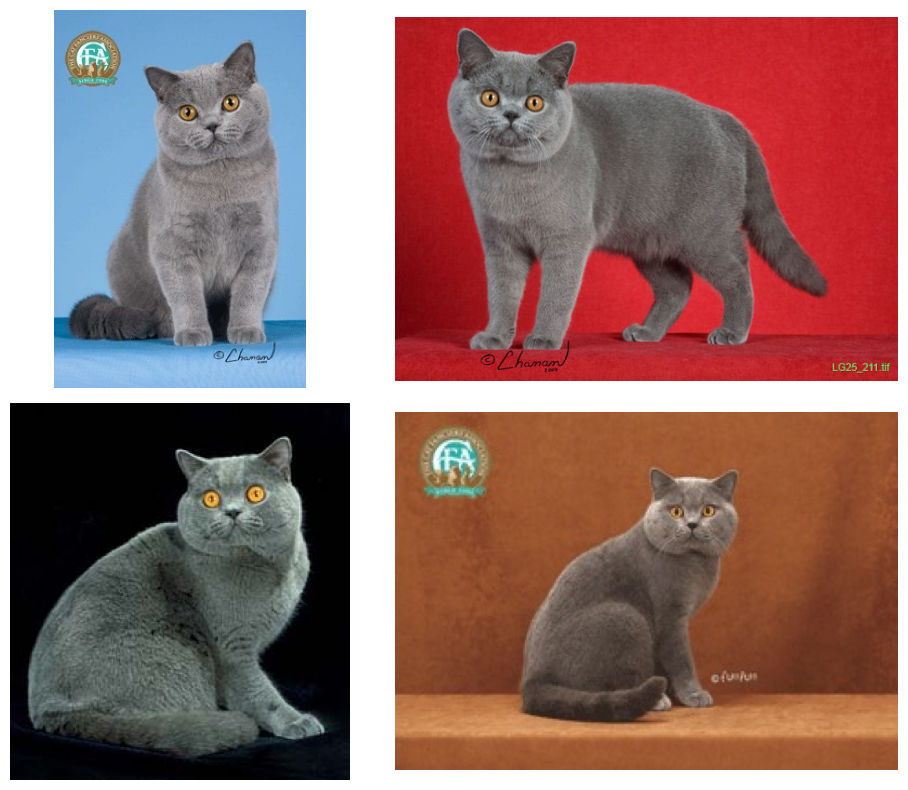

In [22]:
cluster_label = 3
IMAGE_URIs = [filenames[i] for i, val in enumerate(labels) if val == cluster_label][:4]
display_images(IMAGE_URIs)

## Conclusion

In this notebook, we explored the power of Gemini and multimodal embedding models in generating numerical representations of images and text. We began by generating multimodal embeddings of our dataset using the get_image_embedding_from_gcs_uri function. We then utilized ChromaDB to store and retrieve these embeddings, enabling efficient similarity search and clustering capabilities.

By performing similarity searches, we were able to identify images similar to a given test image based on a specified similarity threshold. This technique has various applications in image retrieval, recommendation systems, and more.

Furthermore, we employed the HDBSCAN clustering algorithm to group similar images together. This approach allows us to organize large image datasets and discover patterns based on visual similarity.

Overall, this notebook demonstrated the effectiveness of Gemini and multimodal embedding models in facilitating image analysis and organization. The techniques presented here can be extended to various domains, including e-commerce, social media, and content moderation.